## Querying BigQuery and Loading Data
## Below are code to load each table from BigQuery into a Pandas DataFrame

In [29]:
from google.cloud import bigquery
import pandas as pd

# Initialize the BigQuery client
client = bigquery.Client()
# project "fluid-keyword-454503-a8"
# bq dataset "olist_star_schema"

# Define your SQL queries for each table
query_order_items = """
SELECT shipping_limit_date, price, freight_value, product_id, customer_id 
FROM `fluid-keyword-454503-a8.olist_star_schema.fct_order_items`
"""

query_dim_products = """
SELECT product_id, product_category_name_english 
FROM `fluid-keyword-454503-a8.olist_star_schema.dim_products`
"""

query_dim_customers = """
SELECT customer_id, customer_unique_id, customer_city 
FROM `fluid-keyword-454503-a8.olist_star_schema.dim_customers`
"""

# Load data into Pandas DataFrames
fct_order_items = client.query(query_order_items).to_dataframe()
dim_products = client.query(query_dim_products).to_dataframe()
dim_customers = client.query(query_dim_customers).to_dataframe()

# Convert shipping_limit_date to datetime
fct_order_items['shipping_limit_date'] = pd.to_datetime(fct_order_items['shipping_limit_date'])


In [32]:
dim_customers.head(10)

,customer_id,customer_unique_id,customer_city
0,2201362e68992f654942dc0067c1b716,f7d7fc0a59ef4363fdce6e3aa069d498,rio branco
1,31dbc13addc753e210692eacaea065e4,5dbba6c01268a8ad43f79157bf4454a0,rio branco
2,dad907e170748a35ef4e92238b7308f3,36b1c0516f123351ffa87430416dcae5,rio branco
3,888d2ebe1af2a8c93c75dae5dfc23719,721d1092e1a6460c67e6a0e691d899a3,rio branco
4,8a0108267d9258a0ec9f74381bc9b0de,7a2dc4682890550ebe3b8befcea3d55c,rio branco
5,5880e46677c68394bda62479fd673340,5dbba6c01268a8ad43f79157bf4454a0,rio branco
6,53996870173a3a001a1fb56ef00b9150,2624230437101e0bdcea1e48310d68a3,rio branco
7,cd281c1a7d26cd29a3ed4b029fce7270,086d6b5b5ba195a91aa0a6ec8e75d1a4,rio branco
8,717a3a9459f9006f23e24a684be8408b,5203034a29c3d294713bf8ccbd5d05a6,rio branco
9,2d618e470c95c9b425cbb0cbc42683dd,f7d7fc0a59ef4363fdce6e3aa069d498,rio branco


### 1. Monthly Sales Trends: Group by month to aggregate sales and freight, then plot line charts to visualize trends and seasonality.

### 2. Top-Selling Products: Aggregate by product (or product category) to determine sales frequency and revenue, then use bar charts for visualization.

### 3. Customer Segmentation: By City on top_product_category

In [33]:
# Merge fct_order_items with dim_products to get product category
orders_products = fct_order_items.merge(dim_products, on='product_id', how='left')

# Merge with dim_customers to include customer details
df_full = orders_products.merge(dim_customers, on='customer_id', how='left')

df_full.head(5)

,shipping_limit_date,price,freight_value,product_id,customer_id,product_category_name_english,customer_unique_id,customer_city
0,2017-10-24 23:56:20+00:00,895.0,21.02,a2ff5a97bf95719e38ea2e3b4105bce8,d7fc82cbeafea77bd0a8fbbf6296e387,small_appliances,9de5797cddb92598755a0f76383ddbbb,entre rios de minas
1,2017-10-12 22:24:16+00:00,895.0,21.02,a2ff5a97bf95719e38ea2e3b4105bce8,944b72539d7e1f7f7fc6e46639ef1fe3,small_appliances,3c7e305796add66698959fc7ad176f6b,umuarama
2,2017-10-18 14:49:22+00:00,895.0,21.02,a2ff5a97bf95719e38ea2e3b4105bce8,d9442164acf4b03109425633efaa0cfc,small_appliances,9915eb9f74b6c11aaf04833f65b00e93,paracatu
3,2017-10-24 23:56:20+00:00,895.0,21.02,a2ff5a97bf95719e38ea2e3b4105bce8,d7fc82cbeafea77bd0a8fbbf6296e387,small_appliances,9de5797cddb92598755a0f76383ddbbb,entre rios de minas
4,2017-10-18 14:49:22+00:00,895.0,21.02,a2ff5a97bf95719e38ea2e3b4105bce8,d9442164acf4b03109425633efaa0cfc,small_appliances,9915eb9f74b6c11aaf04833f65b00e93,paracatu


## Import visualization lib

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis 1: Monthly Sales Trends

C:\Users\mmmin\AppData\Local\Temp\ipykernel_4492\2988291362.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_full['month'] = df_full['shipping_limit_date'].dt.to_period('M')


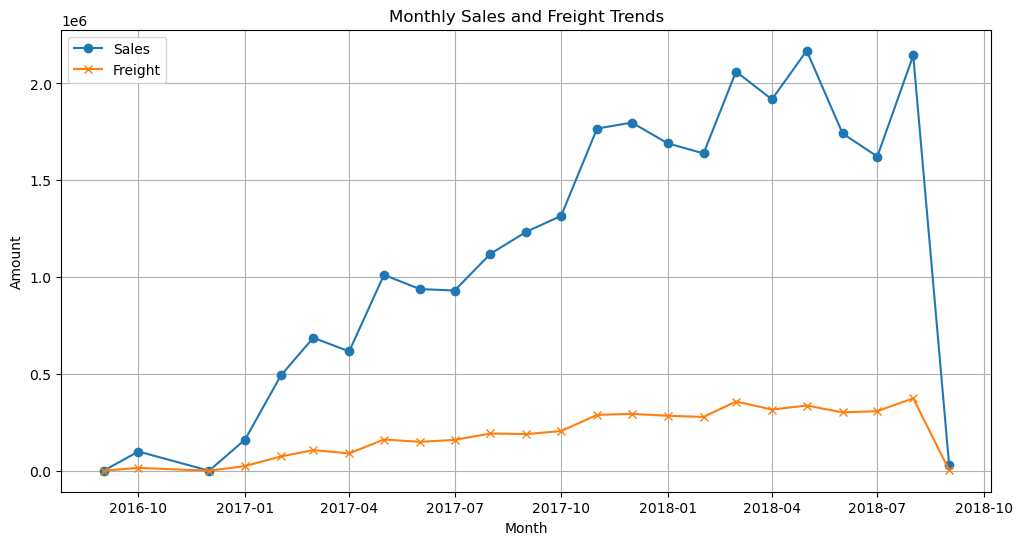

In [ ]:
# Create a month column for grouping
df_full['month'] = df_full['shipping_limit_date'].dt.to_period('M')
# drop rows in place without reassignment for those after 2019 data
df_full.drop(df_full[df_full['month'] > '2018-12'].index, inplace=True)

# Aggregate monthly sales and freight
monthly_sales = df_full.groupby('month').agg(
    total_sales=('price', 'sum'),
    total_freight=('freight_value', 'sum')
).reset_index()

# Convert 'month' back to a timestamp for plotting
monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()

# Plotting

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['month'], monthly_sales['total_sales'], marker='o', label='Sales')
plt.plot(monthly_sales['month'], monthly_sales['total_freight'], marker='x', label='Freight')
plt.title('Monthly Sales and Freight Trends')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()


# Analysis 2: Top-Selling Products

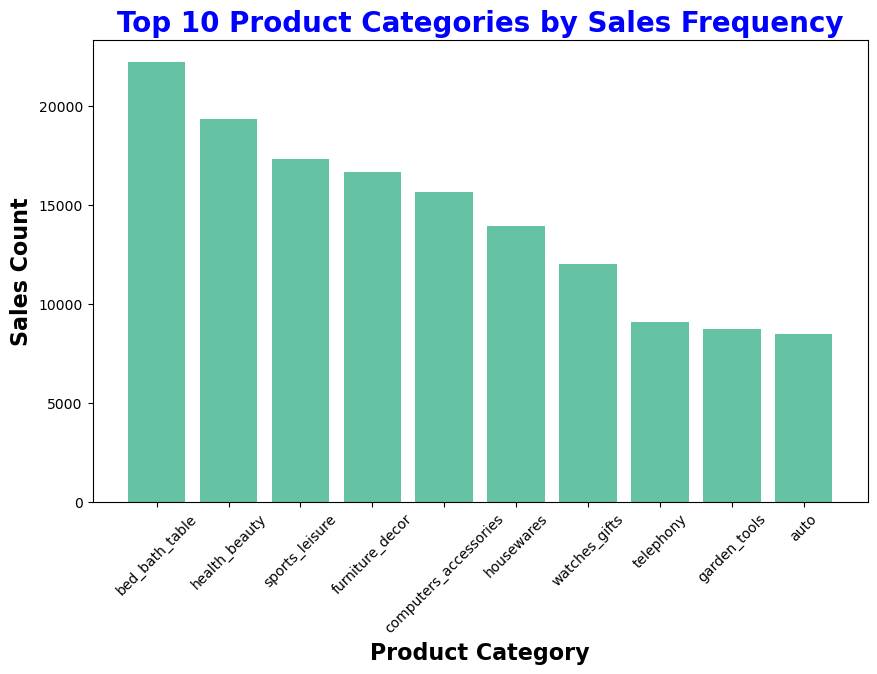

In [84]:
# Group by product_id and product_category_name_english
product_sales = df_full.groupby(['product_category_name_english']).agg(
    sales_count=('price', 'count'),
    total_revenue=('price', 'sum')
).reset_index()

# Identify top 10 products by sales count
top_products = product_sales.sort_values(by='sales_count', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10,6))
plt.bar(top_products['product_category_name_english'], top_products['sales_count'])
plt.title('Top 10 Product Categories by Sales Frequency',fontsize=20,fontweight='bold',color='blue')
plt.xlabel('Product Category',fontsize=16,fontweight='bold',color='black')
plt.ylabel('Sales Count',fontsize=16,fontweight='bold',color='black')
plt.xticks(rotation=45)
plt.show()


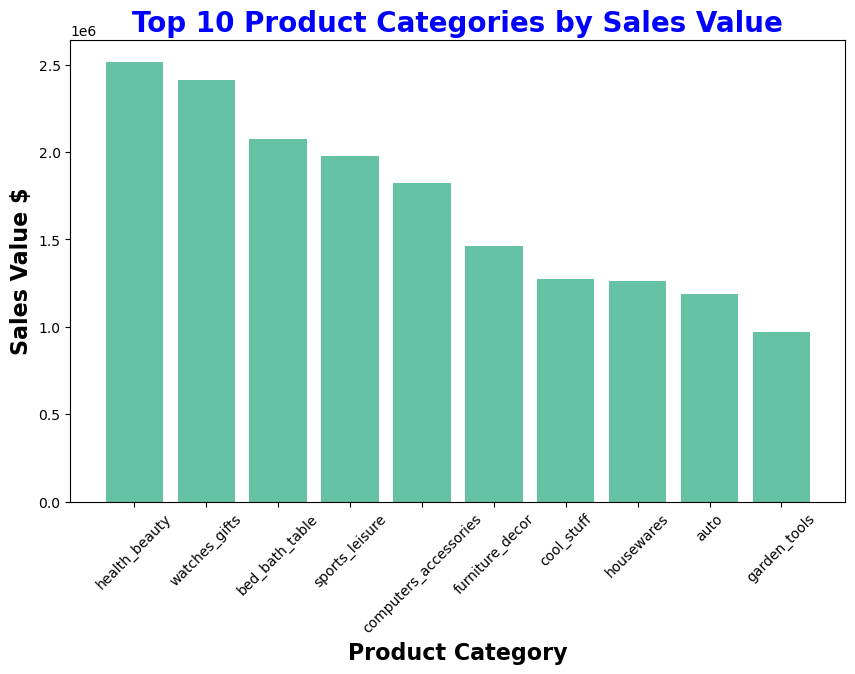

In [85]:
# Identify top 10 products by sales count
top_products = product_sales.sort_values(by='total_revenue', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10,6))
plt.bar(top_products['product_category_name_english'], top_products['total_revenue'])
plt.title('Top 10 Product Categories by Sales Value',fontsize=20,fontweight='bold',color='blue')
plt.xlabel('Product Category',fontsize=16,fontweight='bold',color='black')
plt.ylabel('Sales Value $',fontsize=16,fontweight='bold',color='black')
plt.xticks(rotation=45)
plt.show()

# Analysis 3: Customer Segmentation by Purchase Behavior

We will only consider top 3 selling products category in each city


In [ ]:
city_category_sales = df_full.groupby(['month', 'customer_city', 'product_category_name_english']).agg(
    total_sales=('price', 'sum'),
    order_count=('price', 'count')  # Count of orders
).reset_index()

# Sort first by city, then by total sales in descending order
city_category_sales_sorted = city_category_sales.sort_values(['customer_city', 'total_sales'], ascending=[True, False])

# Keep only the top 3 product categories for each city
top3_per_city = city_category_sales_sorted.groupby('customer_city').head(3)

C:\Users\mmmin\AppData\Local\Temp\ipykernel_4492\4076767908.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['customer_city'] = pd.Categorical(filtered_data['customer_city'], categories=city_sales_total.index, ordered=True)
C:\Users\mmmin\AppData\Local\Temp\ipykernel_4492\4076767908.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = filtered_data.pivot_table(


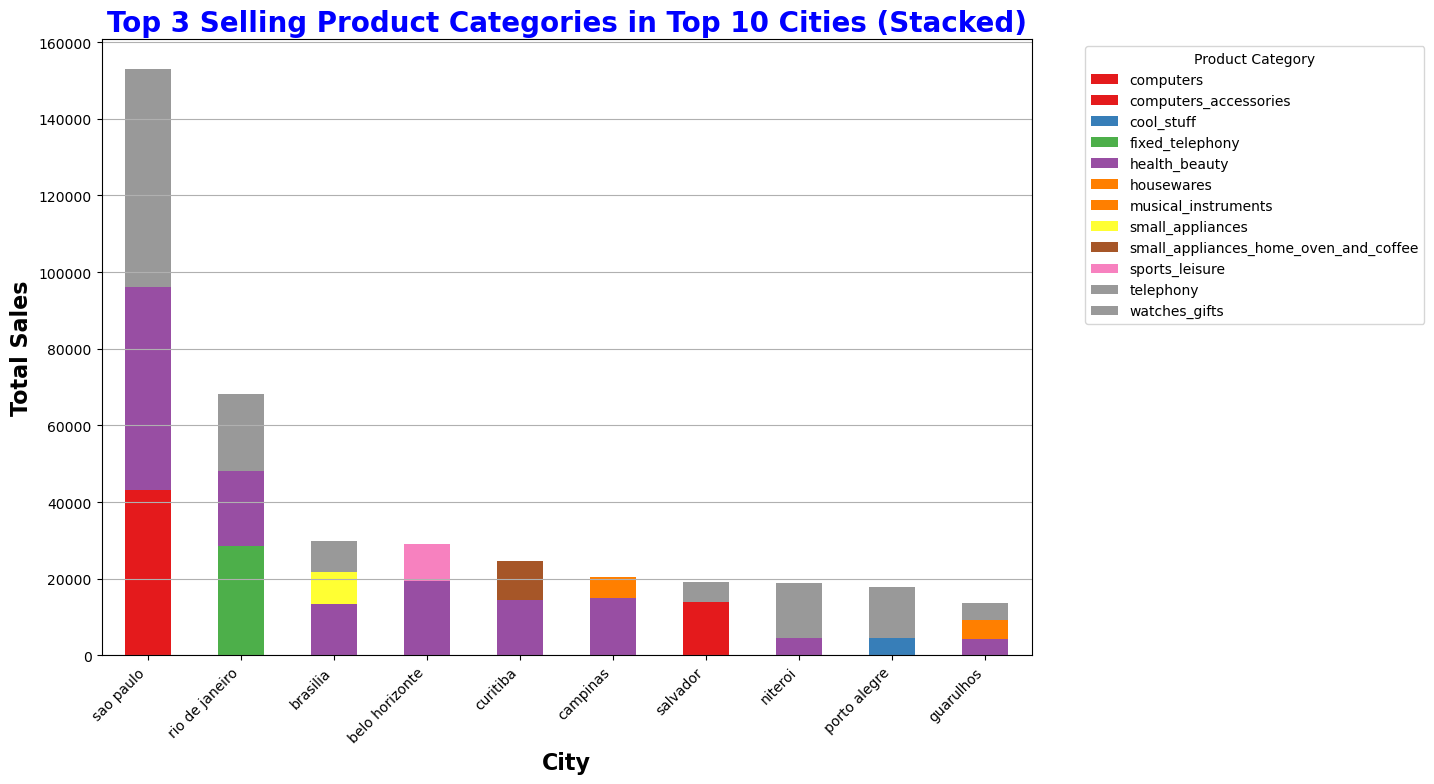

In [90]:
# Step 1: Get the top 10 cities by total sales
top_cities = df_full.groupby('customer_city')['price'].sum().nlargest(10).index.tolist()

# Step 2: Filter top 3 product categories only for these cities
filtered_data = top3_per_city[top3_per_city['customer_city'].isin(top_cities)]

# Step 3: Calculate total sales per city for sorting
city_sales_total = filtered_data.groupby('customer_city')['total_sales'].sum().sort_values(ascending=False)

# Step 4: Reorder the filtered data based on total sales
filtered_data['customer_city'] = pd.Categorical(filtered_data['customer_city'], categories=city_sales_total.index, ordered=True)

# Step 5: Pivot data for a stacked bar chart
pivot_data = filtered_data.pivot_table(
    index='customer_city',
    columns='product_category_name_english',
    values='total_sales',
    aggfunc='sum',
).fillna(0)  # Fill NaN with 0 in case there are missing product categories for any city

# Step 6: Plot stacked bar chart
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="Set1")

# Step 7: Add labels and format
plt.title("Top 3 Selling Product Categories in Top 10 Cities (Stacked)",fontsize=20,fontweight='bold',color='blue')
plt.xlabel("City",fontsize=16,fontweight='bold',color='black')
plt.ylabel("Total Sales",fontsize=16,fontweight='bold',color='black')
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.show()


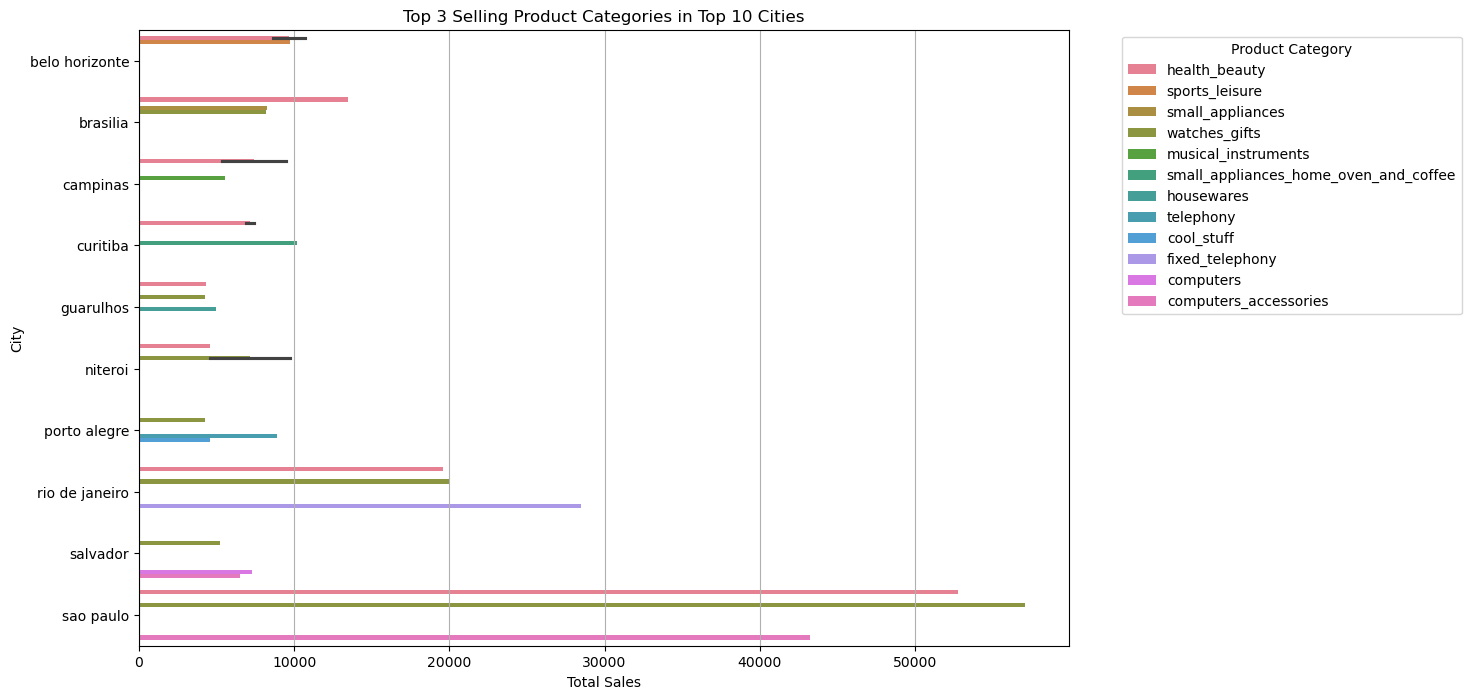

In [ ]:
#Analysis 3: Customer Segmentation by Purchase Behavior

# Group data by month, city, and product category
city_category_sales = df_full.groupby(['month', 'customer_city', 'product_category_name_english']).agg(
    total_sales=('price', 'sum'),
    order_count=('price', 'count')  # Count of orders
).reset_index()

# Sort first by city, then by total sales in descending order
city_category_sales_sorted = city_category_sales.sort_values(['customer_city', 'total_sales'], ascending=[True, False])

# Keep only the top 3 product categories for each city
top3_per_city = city_category_sales_sorted.groupby('customer_city').head(3)

# Step 1: Get the top 10 cities by total sales
top_cities = df_full.groupby('customer_city')['price'].sum().nlargest(10).index.tolist()

# Step 2: Filter top 3 product categories only for these cities
filtered_data = top3_per_city[top3_per_city['customer_city'].isin(top_cities)]

# Step 3: Create a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_data, y='customer_city', x='total_sales', hue='product_category_name_english')

# Formatting
plt.title("Top 3 Selling Product Categories in Top 10 Cities",fontsize=20,fontweight='bold',color='blue')
plt.xlabel("Total Sales",fontsize=16,fontweight='bold',color='black')
plt.ylabel("City",fontsize=16,fontweight='bold',color='black')
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x')

# Show plot
plt.show()


C:\Users\mmmin\AppData\Local\Temp\ipykernel_4492\1190697490.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['customer_city'] = pd.Categorical(filtered_data['customer_city'], categories=city_sales_total.index, ordered=True)
C:\Users\mmmin\AppData\Local\Temp\ipykernel_4492\1190697490.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = filtered_data.pivot_table(


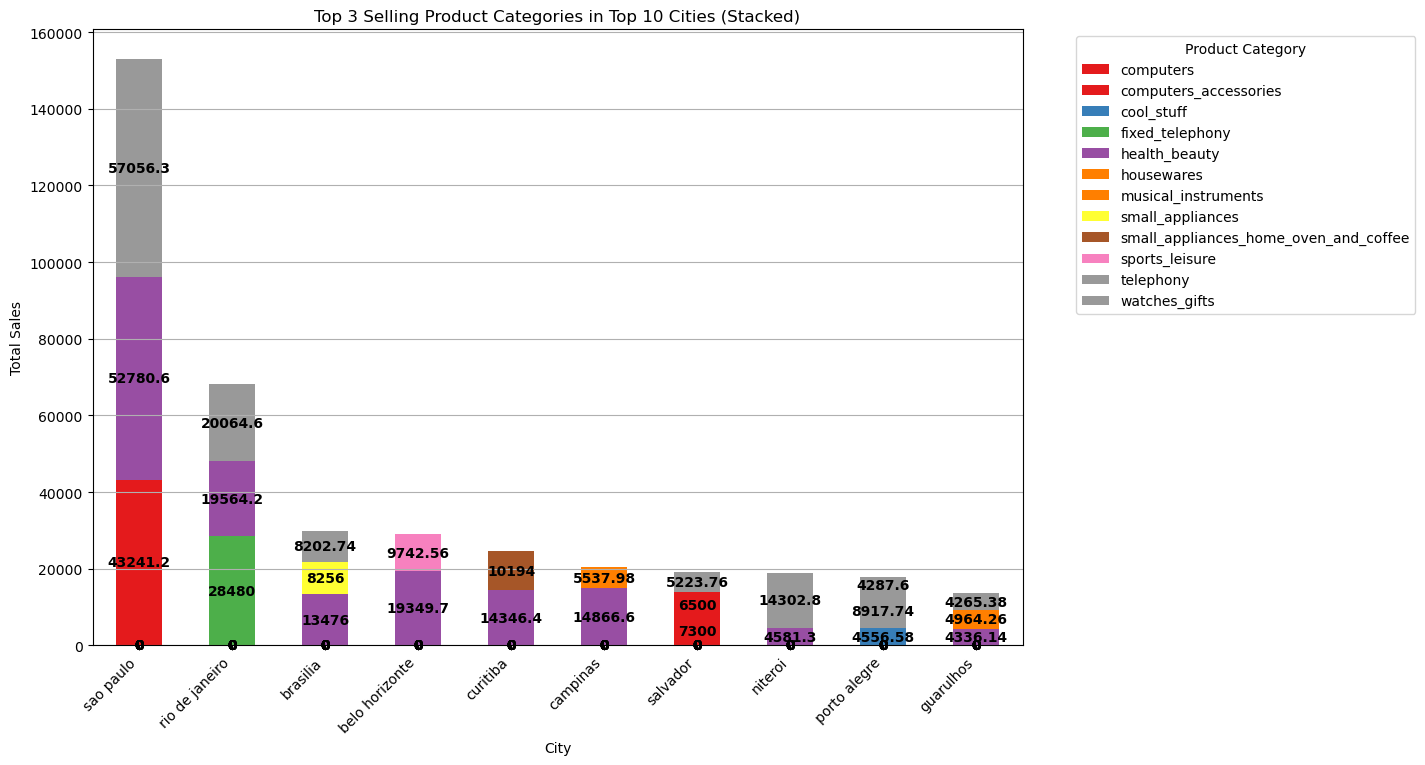

In [ ]:
# Step 1: Get the top 10 cities by total sales
top_cities = df_full.groupby('customer_city')['price'].sum().nlargest(10).index.tolist()

# Step 2: Filter top 3 product categories only for these cities
filtered_data = top3_per_city[top3_per_city['customer_city'].isin(top_cities)]

# Step 3: Calculate total sales per city for sorting
city_sales_total = filtered_data.groupby('customer_city')['total_sales'].sum().sort_values(ascending=False)

# Step 4: Reorder the filtered data based on total sales
filtered_data['customer_city'] = pd.Categorical(filtered_data['customer_city'], categories=city_sales_total.index, ordered=True)

# Step 5: Pivot data for a stacked bar chart
pivot_data = filtered_data.pivot_table(
    index='customer_city',
    columns='product_category_name_english',
    values='total_sales',
    aggfunc='sum',
).fillna(0)  # Fill NaN with 0 in case there are missing product categories for any city

# Step 6: Plot stacked bar chart
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="Set1")

# Step 7: Add labels inside the bars using `bar_label()`
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='black', fontsize=10, fontweight='bold')

# Step 8: Add labels and format
plt.title("Top 3 Selling Product Categories in Top 10 Cities (Stacked)",fontsize=20,fontweight='bold',color='blue')
plt.xlabel("City",fontsize=16,fontweight='bold',color='black')
plt.ylabel("Total Sales",fontsize=16,fontweight='bold',color='black')
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.show()
